# Anomaly and Novelty Detection


In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

df_train = pd.read_csv('train.csv')
X_test   = pd.read_csv('test.csv')

### Data Pre-processing

In [4]:
df_train['is_anomaly'] = np.where(df_train['is_anomaly'] == False, 0, 1) 
df_train["Is_anomaly"] = df_train['is_anomaly'].values

df_train.drop('is_anomaly', axis = 1 ,inplace = True)

X_train = df_train[['timestamp','value','predicted']]
y_train = df_train['Is_anomaly']
df_train.head(10)

,timestamp,value,predicted,Is_anomaly
0,1425008573,42,44.072500,0
1,1425008873,41,50.709390,0
2,1425009173,41,81.405120,0
3,1425009473,61,39.950367,0
4,1425009773,44,35.350160,0
5,1425010073,27,27.713638,0
6,1425010373,37,41.545710,0
7,1425010673,36,38.743620,0
8,1425010973,49,40.859787,0
9,1425011273,36,25.444733,0


### Anomaly Statistics

In [3]:
print("Total Transactions:  ",len(df_train))

Anomalies = df_train[df_train['Is_anomaly']==True]
print("Anomaly Transactions:",len(Anomalies))

Valid = df_train[df_train['Is_anomaly']==False]
print("Valid   Transactions:",len(Valid))

anomaly_fraction = len(Anomalies)/float(len(df_train))
valid_fraction   = len(Valid)/float(len(df_train))

print("Percentage of Anomalous Transactions:",round((anomaly_fraction*100),3), '%')
print("Percentage of Valid Transactions:    ",round((valid_fraction*100),3), '%')

Total Transactions:   15830
Anomaly Transactions: 776
Valid   Transactions: 15054
Percentage of Anomalous Transactions: 4.902 %
Percentage of Valid Transactions:     95.098 %


### Anomaly Identification

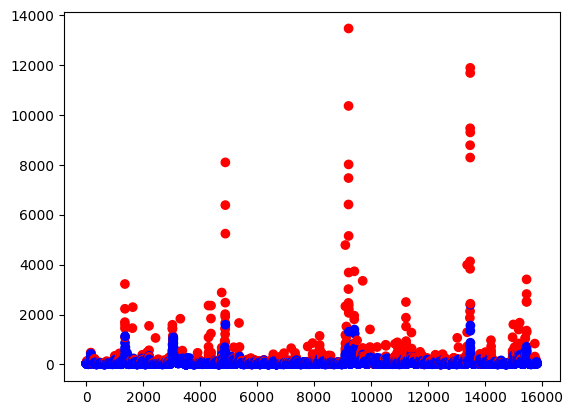

In [4]:
colors = np.where(df_train["Is_anomaly"] == False,'b','r')

plt.scatter(range(15830), df_train['value'], c = colors)

Text(0, 0.5, 'kNN Distances')

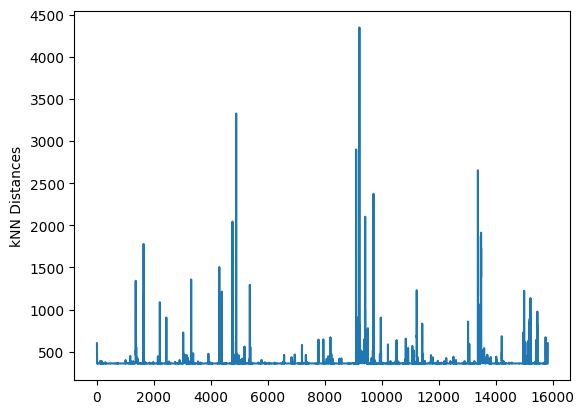

In [5]:
from sklearn.svm import OneClassSVM
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# Specify optimal outlier detectors 
SVM_detector = OneClassSVM(kernel='rbf', gamma=0.001 ,nu=0.001).fit(df_train.values)
kNN_detector = NearestNeighbors(n_neighbors = 5).fit(df_train.values)
IRF_detector = IsolationForest(n_estimators  = 100, 
                               max_samples   = 50, 
                               contamination = 0.03, 
                               bootstrap     = True, 
                               random_state  = 99).fit(df_train.values)
LOF_detector_predictor = LocalOutlierFactor(n_neighbors = 2, 
                                                      algorithm   = 'brute', 
                                                      leaf_size   = 10, 
                                                      metric      = 'minkowski',
                                                      novelty     = False, 
                                                      p           = 1, 
                                                      metric_params = None, 
                                                      contamination = 0.03,
                                                      n_jobs        = -1).fit_predict(df_train.values)

# Predict 
SVM_predictions    = SVM_detector.predict(df_train.values)
distances, indexes = kNN_detector.kneighbors(df_train.values)
IRF_predictions    = IRF_detector.predict(df_train.values)

# Plot distances in kNN
plt.plot(distances.mean(axis =1))
plt.ylabel('kNN Distances')

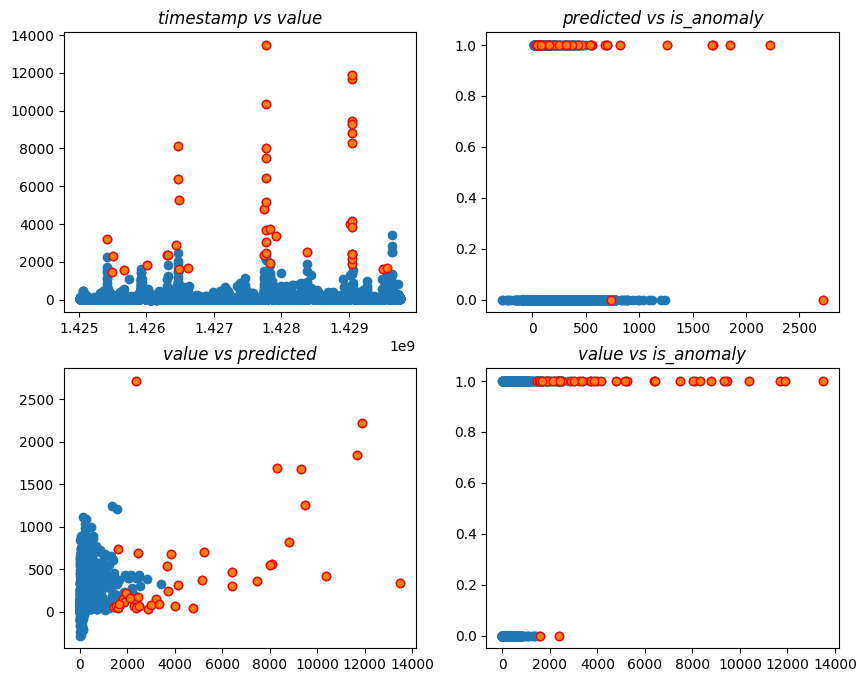

In [6]:
# Filter anomalies
kNN_outlier_values = df_train[distances.mean(axis = 1) > 1000] # visually set threshold values > 1000
SVM_outlier_values = df_train[(SVM_predictions < 0)]
IRF_outlier_values = df_train[(IRF_predictions < 0)]
LOF_outlier_values = df_train[(LOF_detector_predictor < 0)]

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(10,8))

ax[0,0].scatter(df_train['timestamp'], df_train['value'])
ax[0,0].scatter(kNN_outlier_values['timestamp'], kNN_outlier_values['value'], edgecolors = 'r')
ax[0,0].set_title('timestamp vs value', fontstyle='italic')

ax[0,1].scatter(df_train['predicted'], df_train['Is_anomaly'])
ax[0,1].scatter(kNN_outlier_values['predicted'], kNN_outlier_values['Is_anomaly'], edgecolors = 'r')
ax[0,1].set_title('predicted vs is_anomaly', fontstyle='italic')

ax[1,0].scatter(df_train['value'], df_train['predicted'])
ax[1,0].scatter(kNN_outlier_values['value'], kNN_outlier_values['predicted'], edgecolors = 'r')
ax[1,0].set_title('value vs predicted', fontstyle='italic')

ax[1,1].scatter(df_train['value'], df_train['Is_anomaly'])
ax[1,1].scatter(kNN_outlier_values['value'], kNN_outlier_values['Is_anomaly'], edgecolors = 'r')
ax[1,1].set_title('value vs is_anomaly', fontstyle='italic')
plt.show()